Author: Akshay Chougule

Creation Date: 06-Feb-2020

Description: This is a notebook for Human-Protein-Atlas-Competition.

Change log: The changes made wrt to the baseline
- Add more tranforms
- Use slightly bigger images, instead of 128, we will try 224 (so reduce the batch size to 32)
- Use a different metrics instead of f1beta
- Try diffrent model architecture

In [1]:
import pandas as pd
import wget
import time
import os
import copy

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [3]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [4]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [5]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [8]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_224by224',suffix='.png')

In [9]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_224by224',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [10]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
7;1;2;0,1,0,25;2,0
Path: /home/ubuntu/datasets/human-protein-atlas>

In [11]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
7;2,3,1,11;3;0,25
Path: /home/ubuntu/datasets/human-protein-atlas>

In [12]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train and 20% in validation databunch as specified. Alos the test data count match.

In [13]:
data = (src.transform(tfms, size=224)
        .databunch(bs = 32).normalize(imagenet_stats))

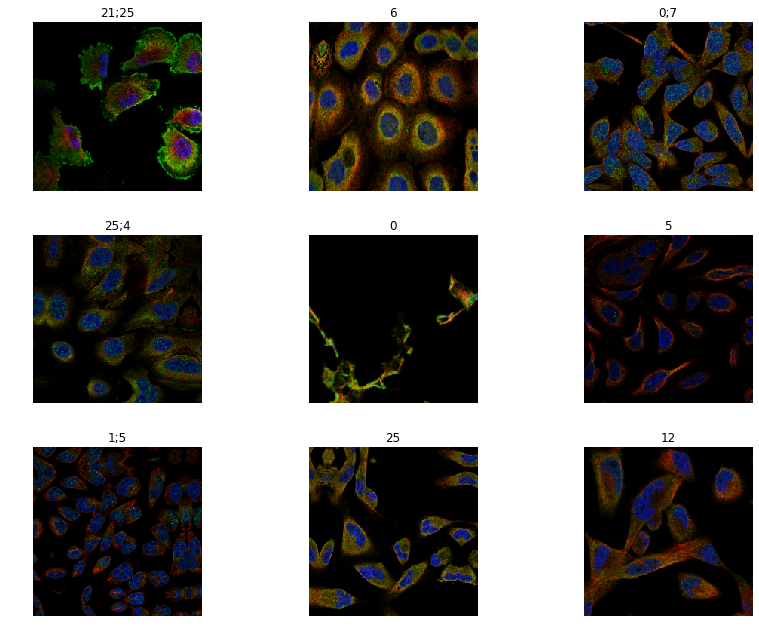

In [14]:
data.show_batch(rows=3, figsize=(12,9))

In [15]:
arch = models.resnet152
acc_02 = partial(accuracy_thresh, thresh=0.2)
#f1_score = partial(fbeta, thresh=0.2, beta=1)

In [16]:
F1 = MultiLabelFbeta(beta=2, average="macro")
#f1-macro = partial(MultiLabelFbeta, beta=2, average="macro")

In [17]:
setattr(src, 'device', 'cuda') 

In [18]:
learn = cnn_learner(data, arch, metrics=F1)

In [15]:
learn.data.batch_size

32

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,MultiLabelFbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


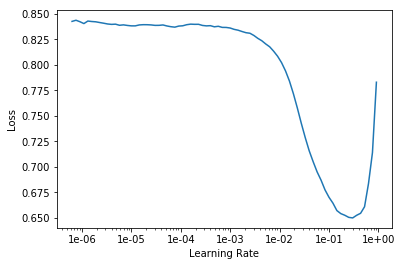

In [17]:
learn.recorder.plot()

In [19]:
lr = 0.01

In [34]:
torch.cuda.empty_cache()

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.154018,0.148623,0.134935,04:16
1,0.141573,0.137687,0.198614,04:17
2,0.133470,0.129213,0.225097,04:18
3,0.127007,0.124694,0.271398,04:18
4,0.121201,0.125079,0.262683,04:17


In [22]:
# for size 62
# learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.172146,0.164291,0.924623,0.352332,00:36
1,0.159438,0.158683,0.932273,0.367234,00:37
2,0.155335,0.153910,0.931985,0.384507,00:37
3,0.152571,0.151191,0.934313,0.400776,00:37
4,0.151080,0.149926,0.933940,0.410561,00:38


In [21]:
learn.save('stage-1-F1-macro-rn152')

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


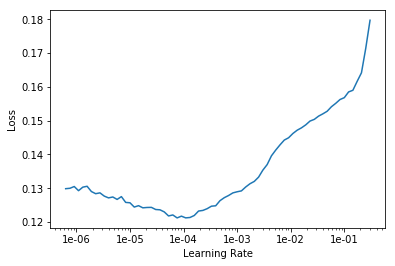

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.131765,0.131391,0.223143,05:44
1,0.125967,0.154718,0.261665,05:45
2,0.122100,0.138351,0.269411,05:45
3,0.115671,0.127179,0.300476,05:45
4,0.112879,0.119966,0.316439,05:46


In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.117564,0.119387,0.300447,05:42
1,0.119625,0.136583,0.289968,05:45
2,0.110408,0.154117,0.311086,05:47
3,0.108852,0.113002,0.328088,05:47
4,0.103433,0.114014,0.340547,05:47


In [26]:
learn.save('stage-2-F1-macroavg-rn152')

### Testing the data

In [27]:
#learn.load('stage-2-rn152')

In [28]:
learn.data.batch_size

32

__Making the predictions__

In [29]:
preds, _ = learn.get_preds(DatasetType.Test)

In [30]:
type(preds), preds.shape

(torch.Tensor, torch.Size([11702, 28]))

In [31]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [32]:
labelled_preds[:5]

['2', '0', '0 21 25', '0 25', '0 25']

In [33]:
len(labelled_preds)

11702

In [34]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_224by224/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

In [35]:
fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_224by224/','')
fnames[0]

'00008af0-bad0-11e8-b2b8-ac1f6b6435d0'

In [36]:
df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])

In [37]:
df.head(20)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 25
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0 25


In [38]:
df.to_csv('protein_classification.csv', header=True, index=False)

In [39]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Revised Model w threshold 0.2"

100%|█████████████████████████████████████████| 484k/484k [00:00<00:00, 725kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [40]:
# View results
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt

In [41]:
!cat results.txt

fileName                    date                 description                            status    publicScore  privateScore  
--------------------------  -------------------  -------------------------------------  --------  -----------  ------------  
protein_classification.csv  2020-02-07 00:30:26  Revised Model w threshold 0.2          complete  0.30987      0.28517       
protein_classification.csv  2020-02-06 19:51:34  Baseline Model v5 with threshold 0.15  complete  0.22196      0.20771       
protein_classification.csv  2020-02-06 19:50:34  Baseline Model v4 with threshold 0.17  complete  0.21858      0.20388       
protein_classification.csv  2020-02-06 19:48:26  Baseline Model v3 with thrsd 0.25      complete  0.19699      0.18535       
protein_classification.csv  2020-02-06 19:42:10  Baseline Model v2 with threshold 0.2   complete  0.20878      0.19654       
protein_classification.csv  2020-02-06 19:22:45  Baseline Model                         complete  0.20878      0.19654

In [42]:
sample_submission = pd.read_csv(data_root+'sample_submission.csv')
sample_submission.head(5)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


Let's try playing around with the threshold

In [44]:
thresholds = [0.22,0.18,0.16,0.14]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_224by224/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_thresh'+str(thresh)+'.csv', header=True, index=False)

In [45]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_thresh0.22.csv -m "Baseline Model v3 with thrsd 0.25"

100%|█████████████████████████████████████████| 480k/480k [00:00<00:00, 628kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [47]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_thresh0.18.csv -m "Baseline Model v3 with thrsd 0.25"

100%|█████████████████████████████████████████| 488k/488k [00:00<00:00, 839kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [48]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_thresh0.16.csv -m "Model-v2 with thrsd 0.16"

100%|█████████████████████████████████████████| 493k/493k [00:00<00:00, 758kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [49]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_thresh0.14.csv -m "Model-v2 with thrsd 0.14"

100%|█████████████████████████████████████████| 499k/499k [00:00<00:00, 799kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [50]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!cat results.txt

fileName                               date                 description                            status    publicScore  privateScore  
-------------------------------------  -------------------  -------------------------------------  --------  -----------  ------------  
protein_classification_thresh0.14.csv  2020-02-07 01:04:05  Model-v2 with thrsd 0.14               complete  0.31406      0.28817       
protein_classification_thresh0.16.csv  2020-02-07 01:02:40  Model-v2 with thrsd 0.16               complete  0.31479      0.28761       
protein_classification_thresh0.18.csv  2020-02-07 01:00:53  Model-v2 with thrsd 0.18               complete  0.31430      0.28700       
protein_classification_thresh0.22.csv  2020-02-07 00:59:27  Model-v2 with thrsd 0.22               complete  0.30140      0.28307       
protein_classification.csv             2020-02-07 00:30:26  Model-v2 with thrsd 0.20               complete  0.30987      0.28517       
protein_classification.csv             20